# Flexural and thermal subsidence in the 1.1 Ga Midcontinent Rift

* [Implementations of lithospheric flexure and thermal subsidence theory](#the_destination)
    * [Simple flexural of elastic lithosphere under a line load](#line_load)
    * [Thermal subsidence](#thermal_sub)
* [Midcontinent Rift background](#MCR_background)
* [Parameterizing the model](#parameters)
    * [Flexural rigidity of Laurentian craton](#flex_rigidity)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

# Motivation

## Midcontinent Rift Evolution

The evolution of the Midcontinent Rift has been discretized into four magmatic intervals: the early, latent, main, and late stages. Occasional felsic volcanism accompanied these stages, so U-Pb dates are the primary constraint on the timing of these distinct magmatic intervals. This timeline of rift development is based on exposure that is very limited relative to the size of the rift inferred from gravity and seismic data and therefore may be incomplete. A thorough understanding of the rift's subsidence history could elucidate just how limited these past interpretations of rift evolution may be. For instance, the latent stage is characterized by quiescent volcanism as interpretted from unconformities within the volcanic sequence. However, if the flexural subsidence of the MCR resulted in peripheral bulging, it is plausible that some of these unconformities may instead be a result of preferential erosion. This is just one example of how a thorough understanding of MCR subsidence could have implications for the broader evolution of the MCR and our interpretations of its history from its present structure. 

## Potential Influence on Paleomagnetic Results

The subsidence history of the MCR is strongly tied to the degree of lithospheric thinning throughout rift development, and is therefore related to the total amount of offset between either side of the MCR limbs. The magnitude of this offset (the amount of spreading actually attained during rifting) can potentially have strong influences on the paleolatitudes interpretted through paleomagnetic data. Fortunately, much paleomagnetic data, from which estimates for plate velocity and Mesoproterozoic paleogeography derive, are oriented in such a way relative to the rift that should record reliable paleolatitude of Laurentia regardless of spreading (i.e. paleomagnetic poles from Osler Group, North Shore volcanic group, etc. indicate alignment with a geomagnetic field oriented perpendicular to the direction of rifting). However, given the overall "U"-shaped geometry of the MCR, this is a fortuitous result of the inferred rifting direction only where MCR rocks are largely accessible for paleomagnetic sampling (north and south Lake Superior). *Discuss new Halls2015 paper and influence of Grenville Orogeny, which probably influenced post-rift subsidence but estimates of its degree of influence varies wildly

## Paleogeography, Geologic Setting, and Origins of Rift

Reconciling estimates of thermal subsidence of a modeled, isolated rift system with current seismic observations could elucidate the tectonic setting of the MCR and other potential influences on its post-rift thermal subsidence. MCR thermal subsidence was still under way at the time of the ~1040 Ma Grenville Orogeny, when it is thought MCR normal faults were reactivated as reverse faults, accomodating the [Laurentia-Amazonia]? continental collision. Estimates of overall crustal shortening during this episode vary from 30 km (White1997) to 4000 km (Halls2015). Juxtaposing modeled and observed thermal subsidence in the MCR could provide much-needed clarification to the intensity of this crustal shortening, as such a comparison may reveal just to what degree the thermal subsidence of the MCR was interrupted by the onset of a collisional event. Additionally, if the nature of MCR thermal subsidence is resolvable and not overwhelmed by the influence of the Grenville Orogeny, this could provide insight into the magmatic origin of the MCR. For instance, because the buoyant upwelling of a mantle plume, thermal subsidence would have been both delayed and mitigated by presumed syn-rift lithospheric upwarping. If mantle temperatures were normal (no plume), and MCR volcanism was largely a feature of passive spreading and decompression melting, White1997 showed that post-rift subsidence in the MCR by 1050 Ma would have reached depths far greater (~18 km) than those actually observed (4-8 km). This point is therefore used as an argument for a mantle plume origin of the MCR, in contrast to the argument that MCR was largely a result of far-field stresses due to the rifting of Amazonia from Laurentia and ceased once an oceanic basin formed between the two continents.

<a id='the_destination'></a>

# Lithospheric flexure and thermal subsidence theory

## Thermal subsidence

A widely accepted model of thermal subsidence was proposed by McKenzie (1978), who invoked the concept of a $\beta$ stretching factor. A generalized timeline of this model is outlined as follows: under tensional stresses, the lithosphere thins by a factor of $\beta$. This is followed by the upwelling of hot asthenosphere, which subsequently cools toward the original geotherm and causes lithospheric thickening. This thickening results in the gradual subsidence of the crust, known as **thermal subsidence**. This sequence of events is outlined in the figure below from McKenzie (1978).
<img src="../Data/beta_stretching.png">

Let's write a generalized function for the process of thermal subsidence. I also give some typical values of necessary parameters below.

In [2]:
rho_c_i = 2800 #density of continental crust, 20 degrees, kg m-3
rho_m_i  = 3300 #density of mantle, 1300 degrees, kg m-3
rho_basalt = 2900 #density of newly erupted basalt kg^m-3
y_c = 40000 #thickness of unstretched continental crust, m
y_l = 80000 #thickness of unstretched lithosphere, m
T_o = 20 #temperature at Earth surface, degrees 
T_m = 1550 #temperature at base of lithosphere
K = 3 #conductivity W m^-1 s^-1
k  = 1e-6 #diffusivity m^2 s^-1
C = 1000 #heat capacity K kg^-1 degrees C ^-1
a = 3.28e-5 # volumetric coefficient for thermal expansion, degree C^-1
E = 0.6e11 # Young's Modulus for Appalachian lithosphere, Pa
v = 0.15 # Poisson's ratio for App. Litho

T_c = (T_m-T_o)/2 * (y_c/y_l) #temperature at base of crust
T_sc = 0.5*(T_m + (y_c/y_l)*(T_m-T_o)); #temperature at base of mantle lithosphere

rho_c = rho_c_i*(1-a*T_c) #average density of crust
rho_sc = rho_m_i*(1 - a*(T_sc - T_m)) #average density of mantle lithosphere, sub crustal, Kg m^-3
rho_m = rho_m_i #average density of mantle
tau = (y_l**2)/((sp.pi**2)*k) #characteristic conductive cooling time

In [3]:
def summation(m,t,beta):
    m_exp = (2*m)+1
    return (1/((m_exp)**2))*((beta/(m_exp*np.pi))*np.sin(m_exp*np.pi/beta))*np.exp(-(m_exp**2)*(t/tau))

In [4]:
# define elevation as a function of time and stretching factor beta
def e(t,beta,temp):
    #modeling thermal subsidence for variety of B
    B = beta
    r = (B/sp.pi)*np.sin(sp.pi/B)
    E_o = ((4*y_l*rho_m*a*temp)/((sp.pi**2)*(rho_m - rho_basalt)))
#     for i in range(0,1000000,10000):
#         sum_term = np.sum(summation(i,t,beta))
    return E_o*r*np.exp(-t/tau)

In [5]:
# initial subsidence
def S_i(t,beta):
    return (y_l*(((rho_m-rho_c)*(y_c/y_l)*(1-(a*T_m*y_c/y_l)))-(a*T_m*rho_m/2))*(1-(1/beta)))/((rho_m*(1-(a*T_sc)))-rho_c)

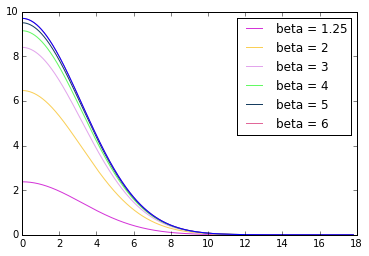

In [6]:
for beta_factor in [1.25,2,3,4,5,6]:
    time = []
    elevation = []
    for t in range(0,10000000000000000,100000000000):
        time.append(np.sqrt(t/60/60/24/365/1000000))
        #time.append(np.sqrt(t))
        elevation.append(e(t,beta_factor,T_sc)/1000)
    plt.plot(time, elevation, color=np.random.rand(3), label='beta = %s'%(str(beta_factor)))
    
plt.plot(time, elevation)
#plt.ylim(max(elevation)+1000)
plt.legend()
plt.show()

It is a bit more intuitive to view this in terms of total elevation change, so we define that below.

In [7]:
def S_tot(t,beta,temp):
    if t==0:
        # use initial subsidence value (dependent on unstretched lithospheric thickness)
        return S_i(t,beta)
    else:
        return -(e(0,beta,temp) - e(t,beta,temp))

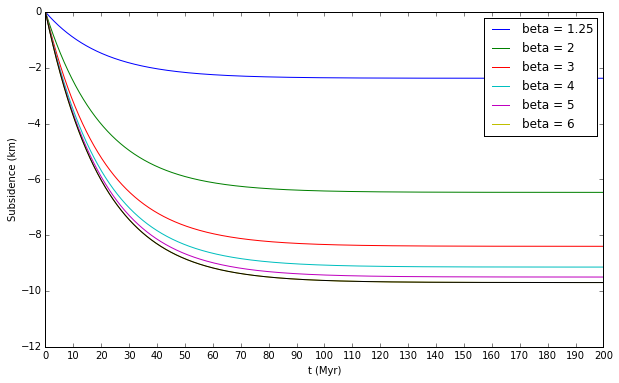

In [8]:
plt.figure(figsize=(10,6))
for beta_factor in [1.25,2,3,4,5,6]:
    time = []
    elevation = []
    for t in range(0,10000000000000000,100000000000):
        time.append(t/60/60/24/365/1000000)
        #time.append(np.sqrt(t))
        elevation.append(S_tot(t,beta_factor,T_sc)/1000)
    #plt.plot(time, elevation, color=np.random.rand(3), label='beta = %s'%(str(beta_factor)))
    plt.plot(time, elevation, label='beta = %s'%(str(beta_factor)))
    
#plt.colorbar(cax=beta_factor)
    
plt.plot(time, elevation)
plt.ylim(-12,0)
#plt.ymin(-100)
plt.xlim(0,200)
plt.xticks(np.arange(0,210,10))
plt.legend()
plt.xlabel('t (Myr)')
plt.ylabel('Subsidence (km)')
plt.savefig('./Code_output/general_thermal_sub.pdf')
plt.show()

Can't seem to get the inverse correlation between mantle temperature and subsidence as shown by White - there must be some more sophisticated parameters that account for the initial uplift of thinned crust and upwelling plume (the inverse relationship is mostly established because of the initial negative values of subsidence, not the overall linear slope).

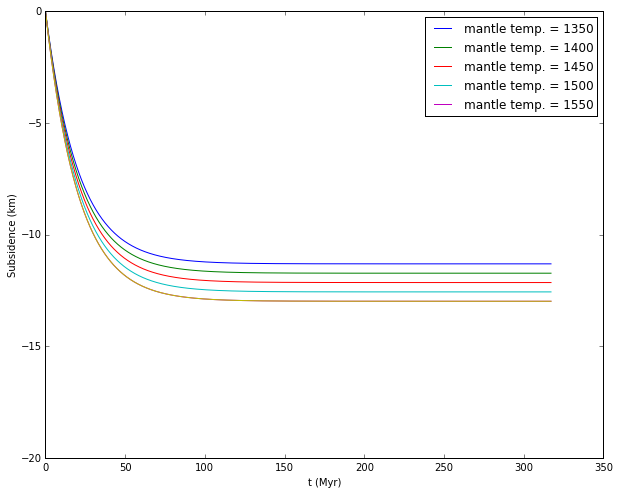

In [9]:
plt.figure(figsize=(10,8))
for temps in [1350,1400,1450,1500,1550]:
    time = []
    elevation = []
    for t in range(0,10000000000000000,100000000000):
        time.append(t/60/60/24/365/1000000)
        #time.append(np.sqrt(t))
        elevation.append(S_tot(t,6,temps)/1000)
    #plt.plot(time, elevation, color=np.random.rand(3), label='beta = %s'%(str(beta_factor)))
    plt.plot(time, elevation, label='mantle temp. = %s'%(str(temps)))
    
#plt.colorbar(cax=beta_factor)
    
plt.plot(time, elevation)
plt.ylim(-20,0)
plt.legend()
plt.xlabel('t (Myr)')
plt.ylabel('Subsidence (km)')
#plt.savefig('./Code_output/general_thermal_sub.pdf')
plt.show()

<a id='line_load'></a>

## Simple flexural of elastic lithosphere under a line load

We begin with a simple example of lithospheric flexure given by Turcotte and Schubert (2014). The deflection of the lithosphere by a linear load can be represented generally by the fourth order equation:
\begin{equation}
D\frac{d^4 w}{d x^4} + P\frac{d^2 w}{d x^2} + (\rho_m - \rho_c)gw = q_a(x)
\end{equation}
In the case of a line load applied at $x=0$ where horizontal pressure $P=0$ and a distributed applied load $q_a(x)=0$ (except at $x=0$), this equation simplifies to:
\begin{equation}
D\frac{d^4 w}{d x^4} + (\rho_m - \rho_w)gw = 0
\end{equation}
The general solution to this is:
\begin{equation}
w = \frac{V_0 \alpha^3}{8D} e^{x/\alpha}(\cos\frac{x}{\alpha} + \sin\frac{x}{\alpha})
\end{equation}
where $V_0$ is the vertical load, $\alpha$ is the flexural parameter, and $D$ is the flexural rigidity of the loaded plate. These parameters are defined as follows:
\begin{equation}
D\equiv \frac{Eh^3}{12(1-\upsilon ^2)}, \alpha = \Big[ \frac{4D}{(\rho_m - \rho_w)g}\Big] ^{1/4}
\end{equation}
where $h$ is the plate thickness, $E$ is Young's modulus and $\upsilon$ is Poisson's ratio. $V_0$ can be estimated by the observed maximum deflection $w_0$:
\begin{equation}
w_{max} = \frac{V_0\alpha^3}{8D}\\
\text{or}\\
w_{max} = \frac{V_0}{2\alpha (\rho_m - \rho_s)g}
\end{equation}

In [10]:
#define a deflection function of x (distance from center x=0); specify parameters
Y_modulus = 70000000000.0 # 70 GPa
Pois_ratio = 0.25
rho_m = 3300
# use sediment or rift volcanic density, as this is a continental (not oceanic) case
rho_s = 2470
rho_b = 3000
# write deflection as a function of x (distance from center), 
# w_max (maximum deflection observed), 
# and h (thickness of elastic lithosphere)
def deflect(x, w_max, h):
    D = (Y_modulus*(h**3))/(12*(1-(Pois_ratio**2)))
    alpha = ((4*D)/((rho_m-rho_s)*10))**(1/4)
    #V_0 = 2*alpha*(rho_m-rho_s)*10
    V_0 = 2400*(0.5*50000*120000)*10
    w = ((V_0*(alpha**3))/(8*D))*(sp.exp(-x/alpha))*(np.cos(x/alpha)+np.sin(x/alpha))
    #return -w*w_max
    return -w

In [11]:
h = 13600
D = (Y_modulus*(h**3))/(12*(1-(Pois_ratio**2)))
alpha = ((4*D)/((rho_m-rho_s)*10))**(1/4)
print(D,alpha)

1.5651726222222223e+22 52406.606112559464


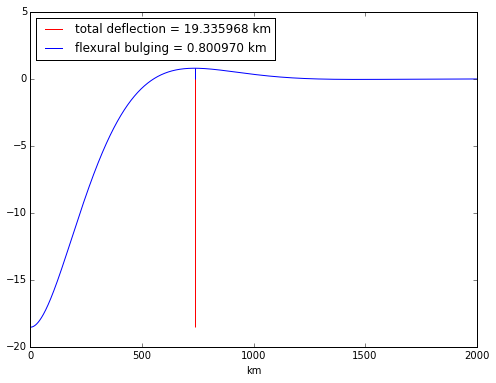

In [16]:
plt.figure(figsize=(8,6))

x_coor = []
y_coor = []

def find_max_coor():
    for i in range(0,len(x_coor)):
        if y_coor[i]==max(y_coor):
            return i
        
for i in range(0,2000000,1000):
    x_coor.append(i/1000)
    y_coor.append(deflect(i,16200,100000)/1000)
    
    
plt.plot(x_coor,y_coor)
plt.vlines(x_coor[find_max_coor()],min(y_coor),max(y_coor),
           'r',label='total deflection = %f km'%(max(y_coor)-min(y_coor)))
plt.vlines(x_coor[find_max_coor()],0,max(y_coor),
           'b',label='flexural bulging = %f km'%(max(y_coor)-0))
plt.xlabel('km')
plt.legend(loc = 'upper left')
plt.savefig('Code_output/flex_fig.pdf')
plt.show()

In [13]:
140*(400000*20000)*10

11200000000000

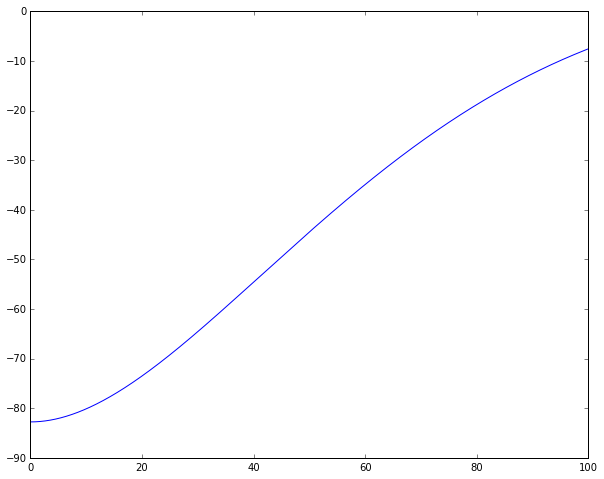

In [14]:
# TRY TO COMBINE THERMAL AND FLEXURAL SUBSIDENCE???
plt.figure(figsize=(10,8))

x_coor = []
y_coor = []

for i in range(0,100000):
    x_coor.append(i/1000)
    y_coor.append(float(deflect(i,16200,13600)+elevation[i])/1000)
    
plt.plot(x_coor,y_coor)
#plt.vlines(x_coor[4010],min(y_coor),y_coor[4010],'r',label='total deflection = %f km'%(max(y_coor)-min(y_coor)))
#plt.legend()
plt.show()

In [15]:
float(deflect(20000,16200,13600)+elevation[20000])

-73498.64502877228

<a id='MCR_background'></a>

# Midcontinent Rift background

The Midcontient Rift (MCR) is a 1.1 Ga rift system in the interior of the Laurentian craton that lasted approximately 30 myr. This rift system is of geodynamic interest because it contains flood basalts averaging $\sim5.8$ km in thickness, a feature typical of large igenous provinces (LIPs) but uncharacteristic of normal rift systems. 120 km wide on average

First, we need to evaluate spreading rate and determine how much the lithosphere was thinned by rifting. We then must invoke a stretching factor $\beta$ (McKenzie, 1978). This will give us elastic thickness at discrete time intervals with which we can then evaluate 1) flexural subsidence due to loading and 2) post-rift thermal subsidence as the perturbed lithosphere cooled.

A key question in this analysis is whether major unconformities observed within the MCR are associated with regions of flexural bulging.

break up into stages, evaluate flexure

<a id='parameters'></a>

# Parameterizing the model

<a id='flex_rigidity'></a>

## Stretching Factor $\beta$

White (1997) estimated a $\beta$ stretching factor of 6 for MCR rifting:
> For an overall stretching ($\beta$) factor of 6, the first phase of lithospheric extension is by a factor of 2.0 from 1110 to 1105 Ma, producing the first period of volcanism starting at 1109 Ma. Continued extension from 1105 to 1100 Ma is much smaller, stretching the lithosphere by a further factor of 1.2: this allows continued gentle subsidence with limited volcanism, in keeping with observations. Finally, an increased rate of stretching by a factor of 2.5 between 1100 and 1094 Ma reproduces the thick sequence of igneous rocks emplaced in the main volcanic phase. After 1094 Ma, the lithosphere is allowed to subside thermally as the mantle beneath the rift cools and as the mantle plume thermal anomaly decays. 

## Flexural rigidity of Laurentian craton

Nyquist and Wang (1988) estimated a post-rift flexural rigidity of $\sim$$10^{21-22}$ N m for the flexing lithosphere.